In [129]:
import os, sys
import random
import json
import nltk 
import csv
import time
import copy
import torch
import numpy as np
import nltk  # $ pip install nltk
from nltk.stem import PorterStemmer
from nltk.corpus import cmudict  # >>> nltk.download('cmudict')
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
from datetime import datetime

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification

from beliefbank_data.utils import generate_assertion, generate_question, find_constraints
import correction_utils

# Load data

In [2]:
constraints_path = "beliefbank_data/constraints_v2.json"
facts_path = "beliefbank_data/silver_facts.json"

In [3]:
constraints = json.load(open(constraints_path))
facts = json.load(open(facts_path))

In [4]:
# entities = list(facts.keys())
# random.shuffle(entities)
# dev_size = 65
# dev_entities = sorted(entities[:dev_size])
# eval_entities = sorted(entities[dev_size:])
# with open("beliefbank_data/dev_entities.txt", "w") as f:
#     f.writelines([e + '\n' for e in dev_entities])
# with open("beliefbank_data/eval_entities.txt", "w") as f:
#     f.writelines([e + '\n' for e in eval_entities])

with open("beliefbank_data/dev_entities.txt", "r") as f:
    dev_entities = [e.strip() for e in f.readlines()]
print(dev_entities)

# with open("beliefbank_data/eval_entities.txt", "r") as f:
#     eval_entities = [e.strip() for e in f.readlines()]
# print(eval_entities)

['american bison', 'baboon', 'birch', 'buck', 'bull', 'calf', 'camel', 'carnivore', 'carp', 'cheetah', 'chick', 'chimpanzee', 'cock', 'crocodile', 'dog', 'dolphin', 'domestic ass', 'duck', 'earthworm', 'elephant', 'european wolf spider', 'foxhound', 'frog', 'gazelle', 'gecko', 'german shepherd', 'giant panda', 'giraffe', 'gladiolus', 'hen', 'horse', 'hound', 'howler monkey', 'hummingbird', 'jaguar', 'lamb', 'leopard', 'lion', 'livestock', 'llama', 'magpie', 'midge', 'mink', 'mullet', 'myna', 'new world blackbird', 'orchid', 'owl', 'ox', 'penguin', 'peony', 'pigeon', 'poodle', 'puppy', 'rabbit', 'rat', 'reptile', 'robin', 'rose', 'salamander', 'starling', 'tiger', 'turkey', 'whale', 'zebra']


# Constraints checking

In [5]:
constraints_yy = set() # A implies B
constraints_yn = set() # A implies not B
for link in constraints['links']:
    s = link['source']
    t = link['target']
    if link['weight'] == 'yes_yes':
        if link['direction'] == 'forward':
            constraints_yy.add((s, t))
        else:
            constraints_yy.add((t, s))
    else:
        constraints_yn.add((s, t))
        constraints_yn.add((t, s))

In [6]:
print(len(constraints_yy))
print(len(constraints_yn))

1836
774


In [7]:
dict_yy = {}
for s, t in constraints_yy:
    if s in dict_yy:
        dict_yy[s].add(t)
    else:
        dict_yy[s] = {t}
dict_yn = {}
for s, t in constraints_yn:
    if s in dict_yn:
        dict_yn[s].add(t)
    else:
        dict_yn[s] = {t}

In [8]:
depth = 10
len_yy = [len(constraints_yy)]
len_yn = [len(constraints_yn)]
for d in range(depth-1):
    temp_yy = copy.deepcopy(dict_yy)
    temp_yn = copy.deepcopy(dict_yn)
    for a, bs in dict_yy.items():
        for b in bs:
            for c in dict_yy.get(b, set()):
                if a == c:
                    continue
                temp_yy[a].add(c)
            for c in dict_yn.get(b, set()):
                if a == c:
                    continue
                if a in temp_yn:
                    temp_yn[a].add(c)
                else:
                    temp_yn[a] = {c}
                if c in temp_yn:
                    temp_yn[c].add(a)
                else:
                    temp_yn[c] = {a}
    del dict_yy
    del dict_yn
    dict_yy = temp_yy
    dict_yn = temp_yn
    len_yy.append(sum([len(v) for v in dict_yy.values()]))
    len_yn.append(sum([len(v) for v in dict_yn.values()]))

In [9]:
for s, ts in dict_yy.items():
    for t in ts:
        constraints_yy.add((s, t))
for s, ts in dict_yn.items():
    for t in ts:
        constraints_yn.add((s, t))
constraints_nn = set([(t, s) for s, t in constraints_yy])

In [10]:
print(len(constraints_yy))
print(len(constraints_yn))

3931
11346


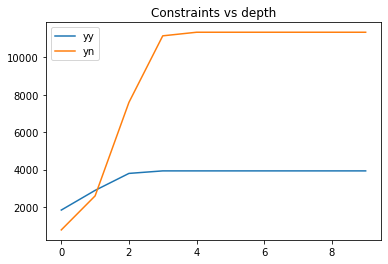

In [11]:
plt.title("Constraints vs depth")
plt.plot(len_yy, label="yy")
plt.plot(len_yn, label="yn")
plt.legend()
plt.show()

In [12]:
for c1, c2 in constraints_yn:
    if c1 == c2:
        print(c1, c2)
        break

In [13]:
dict_nn = {}
for s, t in constraints_nn:
    if s in dict_nn:
        dict_nn[s].add(t)
    else:
        dict_nn[s] = {t}

In [14]:
neighbors = {}
num_neighbors = {}
for s in list(dict_yy.keys()) + list(dict_yn.keys()) + list(dict_nn.keys()):
    neighbors[s] = dict_yy.get(s, set()).union(dict_yn.get(s, set())).union(dict_nn.get(s, set()))
    num_neighbors[s] = len(neighbors[s])

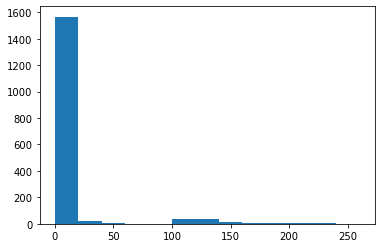

In [15]:
plt.hist(num_neighbors.values(), bins=range(0, max(num_neighbors.values()) + 1, 20))
plt.show()

In [16]:
def check_constraints(relation1, true1, relation2, true2):
    # Is (relation1, true1) & (relation2, true2)  
    if true1 and true2: # Case a
        implies12 = (relation1, relation2) in constraints_yy
        implies21 = (relation2, relation1) in constraints_yy
        contradicts = (relation1, relation2) in constraints_yn or (relation2, relation1) in constraints_yn
    elif true1 and not true2: # Case b
        implies12 = (relation1, relation2) in constraints_yn or (relation2, relation1) in constraints_yn
        implies21 = False
        contradicts = (relation1, relation2) in constraints_yy
    elif not true1 and true2: # Case c
        implies12 = False
        implies21 = (relation1, relation2) in constraints_yn or (relation2, relation1) in constraints_yn
        contradicts = (relation2, relation1) in constraints_yy
    else: # Case d
        implies12 = (relation2, relation1) in constraints_yy
        implies21 = (relation1, relation2) in constraints_yy
        contradicts = False
    return implies12, implies21, contradicts

In [17]:
print(check_constraints("IsA,animal", True, "IsA,mammal", True))
print(check_constraints("IsA,animal", True, "IsA,mammal", False))
print(check_constraints("IsA,animal", False, "IsA,mammal", True))
print(check_constraints("IsA,animal", False, "IsA,mammal", False))

(False, True, False)
(False, False, False)
(False, False, True)
(True, False, False)


In [18]:
print(check_constraints("IsA,animal", True, "IsA,candy", True))
print(check_constraints("IsA,animal", True, "IsA,candy", False))
print(check_constraints("IsA,animal", False, "IsA,candy", True))
print(check_constraints("IsA,animal", False, "IsA,candy", False))

(False, False, False)
(False, False, False)
(False, False, False)
(False, False, False)


# Load models

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
# Downloads a pretty large model
tokenizer = AutoTokenizer.from_pretrained("allenai/macaw-large")
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/macaw-large")
model = model.to(device=device).eval()

In [21]:
# QA Model stuff
def format_question(question_list):
    question_list = ["$answer$ ; $mcoptions$ = (A) yes (B) no; $question$ = " + item \
         for item in question_list]
    return question_list

def predict(question_list, max_bsize=10):
    B = len(question_list)
    question_list = format_question(question_list)
    answer_list_all_yes = ["$answer$ = yes"] * B     # pass in list of "yes"
    
    answers_all = []
    confidences_all = []
    for i in range(0, B, max_bsize):
        j = min(i + max_bsize, B)
        # print(dir(tokenizer))
        inputs = tokenizer.batch_encode_plus(question_list[i:j], max_length = 256, padding=True, truncation=True, return_tensors="pt")
        labels = tokenizer.batch_encode_plus(answer_list_all_yes[i:j], max_length = 15, padding=True, truncation=True, return_tensors="pt") # max_length is set to len("$answer$ = yes")

        # output = model.generate(input_ids, max_length=200)
        # answers = tokenizer.batch_decode(output, skip_special_tokens=True)
        fwd = model(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"].to(device),
                    labels=labels["input_ids"].to(device))
                    # decoder_input_ids=labels["input_ids"], decoder_attention_mask=labels["attention_mask"])
        # output_ids = torch.argmax(fwd.logits, dim=-1)
        # print(tokenizer.batch_decode(output_ids, skip_special_tokens=True))

        # loss
        # loss = fwd.loss # - log(P(y|x))
        # confidence = torch.exp(-loss)
        logits = fwd.logits.reshape((j - i, 7, -1))
        logits = logits[:, 5, :] # Index of yes/no token in answer
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        # yes has input_id 4273, no has input_id 150
        confidence_yes = probs[..., 4273] 
        confidence_no = probs[..., 150]

        answers = (confidence_yes >= confidence_no) # np.array([(ans == "$answer$ = yes") for ans in answers])
        confidences = np.where(answers, confidence_yes, confidence_no)
        answers_all.append(answers)
        confidences_all.append(confidences)
    answers = np.concatenate(answers_all, axis=0)
    confidences = np.concatenate(confidences_all, axis=0)
    return answers, confidences


In [22]:
nli_tokenizer = AutoTokenizer.from_pretrained("ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli")
nli_model = AutoModelForSequenceClassification.from_pretrained("ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli")
nli_model = nli_model.to(device=device).eval()

Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
def nli(sents, nli_tokenizer, nli_model, max_bsize=20):
    """Generates contradiction matrix of shape (N, B, B)"""
    if sents.ndim == 1:
        sents = sents.reshape(1, -1)
    
    N, B = sents.shape
    prem = []
    hypo = []
    for i in range(N):
        for j in range(B):
            for k in range(B):
                prem.append(sents[i][j])
                hypo.append(sents[i][k])

    nli_matrix = []
    size = N * B * B
    for i in range(0, size, max_bsize):
        j = min(i + max_bsize, size)
        tokenized = nli_tokenizer(prem[i:j], hypo[i:j], 
                                  max_length=256, 
                                  return_token_type_ids=True, 
                                  truncation=True,
                                  padding=True)

        input_ids = torch.Tensor(tokenized['input_ids']).to(device).long()
        token_type_ids = torch.Tensor(tokenized['token_type_ids']).to(device).long()
        attention_mask = torch.Tensor(tokenized['attention_mask']).to(device).long()

        nli_outputs = nli_model(input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=None)
        nli_matrix.append(torch.softmax(nli_outputs.logits.detach().cpu(), dim=1))
    nli_matrix = torch.cat(nli_matrix, dim=0)
    nli_matrix = nli_matrix.reshape(N, B, B, 3)
    return nli_matrix.numpy()

# TODO: Mimic nli model, but using constraints graph
def nli_constraints(big_batch, N, B):
    nli_matrix = np.zeros((N, B, B, 3))
    pass

In [24]:
def evaluate(predictions, answers, pred_batch):
    if predictions.ndim == 1:
        predictions = predictions.reshape(1, -1)
    answers = answers.reshape(predictions.shape)
    relations = np.array([rel for ent, rel, pred in pred_batch]).reshape(predictions.shape)
    N, B = predictions.shape
    # predictions, answers, relations hould be size (N, B)
    
    # Calculate accurate examples
    acc = np.sum(predictions == answers)
    
    # Calculate contradictions
    con = 0
    for i in range(N):
        for j in range(B):
            for k in range(j+1, B):
                impl12, impl21, contra = check_constraints( \
                    relations[i, j], predictions[i, j], relations[i, k], predictions[i, k])
                if contra:
                    con += 1
    
    total = predictions.size
    bsize = predictions.shape[0]
    return acc, con, total, bsize

In [25]:
start = time.time()

correction_fn_names = ['do_nothing', 'correction_1', 'correction_2', 'correction_3', 
                       'correction_4', 'correction_5', 'correction_6']
correction_fns = [getattr(correction_utils, fn_name) for fn_name in correction_fn_names]

acc_count = np.array([0] * len(correction_fns))
con_count = np.array([0] * len(correction_fns))
total_count = np.array([0] * len(correction_fns))
num_batches = np.array([0] * len(correction_fns))
flip_count = np.array([0] * len(correction_fns))

N = 10 # Number of entities to sample in a big batch
batch_counter = 0
num_big_batches = 0
big_batch = []

B = 10 # Number of facts for each entity

random.shuffle(dev_entities)
idx_count = 0
idx = 0
while num_batches[0] < 1000:
    if idx == len(dev_entities):
        random.shuffle(dev_entities)
        idx = 0
    entity = dev_entities[idx]
    idx += 1
    idx_count += 1
    
    # Sample set of facts for an entity
    # Sampling method 2
    entity_facts = list(facts[entity].items())
    base = random.choice(entity_facts)
    relation, label = base
    nearby = neighbors.get(relation, set())
    allowed_facts = [f for f in entity_facts if f[0] in nearby]
    if len(allowed_facts) < B - 1:
        continue
    batch = random.sample(allowed_facts, min(B - 1, len(allowed_facts)))
    batch = [base] + batch
    batch = [(entity, rel, label == "yes") for rel, label in batch]
    
    # # Random sampling (method 3)
    # batch = random.sample(list(facts[entity].items()), B)
    # batch = [(entity, relation, true == "yes") for relation, yes in batch]
    
    # Collect batches in big batches
    if batch_counter == 0:
        big_batch = []
    batch_counter += 1
    big_batch.extend(batch)
    if batch_counter < N: # Big batch not full yet, keep accumulating examples
        continue
    # We have a full batch
    batch_counter = 0
    num_big_batches += 1
    
    questions, answers = zip(*[generate_question(*tup) for tup in big_batch])
    questions = list(questions)
    answers = np.array([ans == "Yes" for ans in answers])
    # print("Questions:", question_list)
    # print("Labels (for contradiction):", answer_list)
    
    predictions, confidences = predict(questions, max_bsize=20)
    predictions = predictions.flatten()
    confidences = confidences.flatten()
    # print("QA predictions:", predictions)
    # print("QA confidences:", confidences)
    
    pred_batch = [(ent, rel, predictions[i]) for i, (ent, rel, true) in enumerate(big_batch)]
    assertions = [generate_assertion(*tup) for tup in pred_batch]
    # print("Assertions:", assertions)
    
    assertions = np.array(assertions).reshape(N, B)
    nli_matrix = nli(assertions, nli_tokenizer, nli_model, max_bsize=20)
    # print("NLI probability matrix:\n", nli_matrix)
    
    predictions = predictions.reshape(N, B)
    confidences = confidences.reshape(N, B)
    for i, correction_fn in enumerate(correction_fns):
        corrected, flip_mask = correction_fn(predictions.copy(), confidences.copy(), nli_matrix.copy(), return_flip_mask=True)
        flip_count[i] += np.count_nonzero(flip_mask)
        acc, con, total, bsize = evaluate(corrected, answers, pred_batch)
        acc_count[i] += acc
        con_count[i] += con
        total_count[i] += total
        num_batches[i] += bsize # bsize should be equal to N
    # print(acc, con, total, bsize)
    
    if num_batches[0] % 100 == 0:
        num_pairs = num_batches[0] * B * B
        print(f"Iter {idx_count}: {num_batches[0]} batches, {total_count[0]} facts")
        for i, fn_name in enumerate(correction_fn_names):
            print(f"Correction function {fn_name}:")
            print(f"\tAccurate {acc_count[i]} / {total_count[i]} = {acc_count[i] / total_count[i]}")
            print(f"\tContradictions {con_count[i]} / {num_batches[i]} = {con_count[i] / num_batches[i]}")
            print(f"\tCorrections {flip_count[i]} / {num_batches[i]} = {flip_count[i] / num_batches[i]}")

print("\n==================== Final Results ====================")
num_pairs = num_batches[0] * B * B
print(f"End on iter {idx_count}: {num_batches[0]} {B}x{B} batches, {total_count[0]} facts")
for i, fn_name in enumerate(correction_fn_names):
    print(f"Correction function {fn_name}:")
    print(f"\tAccurate {acc_count[i]} / {total_count[i]} questions = {acc_count[i] / total_count[i]}")
    print(f"\tContradictions {con_count[i]} / {num_batches[i]} batches = {con_count[i] / num_batches[i]} contradictions per batch")
    print(f"\tCorrections {flip_count[i]} / {num_batches[i]} batches = {flip_count[i] / num_batches[i]} flips per batch")

end = time.time()
print("Runtime:", end - start)

Iter 56: 50 batches, 500 facts
Correction function do_nothing:
	Accurate 417 / 500 = 0.834
	Contradictions 86 / 50 = 1.72
	Corrections 0 / 50 = 0.0
Correction function correction_1:
	Accurate 449 / 500 = 0.898
	Contradictions 28 / 50 = 0.56
	Corrections 40 / 50 = 0.8
Correction function correction_2:
	Accurate 439 / 500 = 0.878
	Contradictions 36 / 50 = 0.72
	Corrections 24 / 50 = 0.48
Correction function correction_3:
	Accurate 410 / 500 = 0.82
	Contradictions 120 / 50 = 2.4
	Corrections 43 / 50 = 0.86
Correction function correction_4:
	Accurate 377 / 500 = 0.754
	Contradictions 197 / 50 = 3.94
	Corrections 126 / 50 = 2.52
Correction function correction_5:
	Accurate 133 / 500 = 0.266
	Contradictions 1100 / 50 = 22.0
	Corrections 444 / 50 = 8.88
Correction function correction_6:
	Accurate 276 / 500 = 0.552
	Contradictions 503 / 50 = 10.06
	Corrections 279 / 50 = 5.58
Iter 116: 100 batches, 1000 facts
Correction function do_nothing:
	Accurate 807 / 1000 = 0.807
	Contradictions 210 / 100

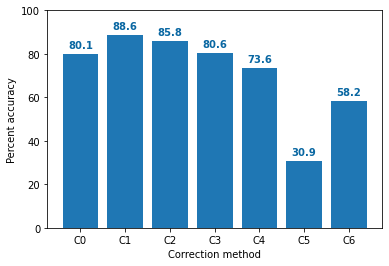

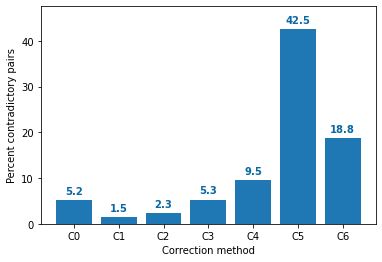

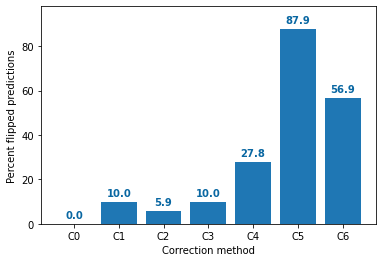

In [128]:
now = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

correction_fn_aliases = [f"C{i}" for i in range(len(correction_fns))]
accuracies = acc_count / total_count * 100
fig, ax = plt.subplots()
ax.bar(correction_fn_aliases, accuracies)
for i, v in enumerate(accuracies):
    ax.text(i, v + 1 + max(accuracies) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, 100)
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent accuracy")
plt.show()
fig.savefig(f"figures/accuracy_{now}.png")

fig, ax = plt.subplots()
contra_rates = con_count / (num_batches * B * (B - 1) / 2) * 100
plt.bar(correction_fn_aliases, contra_rates)
for i, v in enumerate(contra_rates):
    ax.text(i, v + 1 + max(contra_rates) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(contra_rates) + 5, 100))
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent contradictory pairs")
plt.show()
fig.savefig(f"figures/contradict_{now}.png")  

fig, ax = plt.subplots()
flip_rates = (flip_count / total_count) * 100
plt.bar(correction_fn_aliases, flip_rates)
for i, v in enumerate(flip_rates):
    ax.text(i, v + 1 + max(accuracies) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(flip_rates) + 10, 100))
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent flipped predictions")
plt.show()
fig.savefig(f"figures/flipped_{now}.png")